<a href="https://colab.research.google.com/github/Panagiotis-Bosinas/Machine_Learning_Assignments/blob/main/Final_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [125]:
!pip install ydata-profiling

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from ydata_profiling import ProfileReport
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

**Loading data in Dataframes. The two csv files need to be merged using the id columns as indicators, to ensure that the data are sorted properly.**

In [127]:
inputs = pd.read_csv('train_hh_features.csv')
targets = pd.read_csv ('train_hh_gt.csv')
df = inputs.merge(targets, on=['survey_id', 'hhid'])

Using Profile Report to describe the data and determine the correlations between them.

In [128]:
profile = ProfileReport(df, title="Household Features Report")
profile.to_file("report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 89/89 [00:37<00:00,  2.39it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Dropping the columns that don't contain useful for the training process

In [129]:
df = df.drop(columns=['hhid','survey_id','com','strata'],errors='ignore')

In [130]:
df.head()

,weight,utl_exp_ppp17,male,hsize,num_children5,num_children10,num_children18,age,owner,water,...,consumed4200,consumed4300,consumed4400,consumed4500,consumed4600,consumed4700,consumed4800,consumed4900,consumed5000,cons_ppp17
0,75,594.80627,Female,1,0,0,0,75,Owner,Access,...,Yes,No,No,No,Yes,Yes,Yes,Yes,No,25.258402
1,150,1676.27230,Female,2,0,0,0,61,Owner,Access,...,Yes,No,No,No,No,Yes,Yes,No,No,16.996706
2,375,506.93719,Male,5,0,0,2,49,Owner,Access,...,Yes,Yes,No,Yes,Yes,Yes,Yes,No,Yes,13.671848
3,375,824.61786,Male,5,0,0,1,58,Not owner,Access,...,No,Yes,No,No,No,Yes,Yes,No,No,7.189475
4,525,351.47644,Male,7,1,0,0,57,Owner,Access,...,Yes,No,No,Yes,No,Yes,Yes,Yes,No,12.308855


Label encoding for the Boolean variables

In [131]:
bool_cols = [
    'any_nonagric', 'consumed100', 'consumed200', 'consumed300', 'consumed400',
    'consumed500', 'consumed600', 'consumed700', 'consumed800', 'consumed900',
    'consumed1000', 'consumed1100', 'consumed1200', 'consumed1300', 'consumed1400',
    'consumed1500', 'consumed1600', 'consumed1700', 'consumed1800', 'consumed1900',
    'consumed2000', 'consumed2100', 'consumed2200', 'consumed2300', 'consumed2400',
    'consumed2500', 'consumed2600', 'consumed2700', 'consumed2800', 'consumed2900',
    'consumed3000', 'consumed3100', 'consumed3200', 'consumed3300', 'consumed3400',
    'consumed3500', 'consumed3600', 'consumed3700', 'consumed3800', 'consumed3900',
    'consumed4000', 'consumed4100', 'consumed4200', 'consumed4300', 'consumed4400',
    'consumed4500', 'consumed4600', 'consumed4700', 'consumed4800', 'consumed4900',
    'consumed5000']

for col in bool_cols:
    df[col] = df[col].replace({True:1, False:0, 'Yes':1, 'No':0})

In [132]:
df['water'] = df['water'].replace({'No access':0, 'Access':1})
df['toilet'] = df['toilet'].replace({'No access':0, 'Access':1})
df['sewer'] = df['sewer'].replace({'No access':0, 'Access':1})
df['elect'] = df['elect'].replace({'No access':0, 'Access':1})
df['urban'] = df['urban'].replace({'Rural':0, 'Urban':1})
df['employed'] = df['employed'].replace({'Not employed':0, 'Employed':1})
df['male'] = df['male'].replace({'Female':0, 'Male':1})
df['owner'] = df['owner'].replace({'Not owner':0, 'Owner':1})

Mapping for some of the categorical variables

In [133]:
dweltyp_map = {'Detached house': 1,'Multi-family house': 2,
    'Separate apartment': 3,'Communal apartment': 4,
    'Room in a larger dwelling': 5,'Several buildings connected': 6,
    'Several separate buildings': 7,'Improvised housing unit': 8,
    'Other': 99}

educ_max_map = {'Never attended': 0,'Incomplete Primary Education': 1,
    'Complete Primary Education': 2,'Incomplete Secondary Education': 3,
    'Complete Secondary Education': 4,'Incomplete Tertiary Education': 5,
    'Complete Tertiary Education': 6}

sanitation_map = {'A flush toilet':1,'A piped sewer system':2,
                  'A septic tank':3,'Pit latrine':4,
                  'Ventilated improved pit latrine':5,'Pit latrine with slab':6,
                  'Composting toilet':7,'Special case':8,
                  'A flush/pour flush to elsewhere':9,'A pit latrine without slab':10,
                  'Bucket':11,'Hanging toilet or hanging latrine':12,
                  'No facilities or bush or field':13,'Other':14}

sector1d_map = {'Agriculture, hunting and forestry':1,'Fishing':2,
                'Mining and quarrying':3,'Manufacturing':4,
                'Electricity, gas and water supply':5,'Construction':6,
                'Wholesale and retail trade':7,'Hotels and restaurants':8,
                'Transport, storage and communications':9,'Financial intermediation':10,
                'Real estate, renting and business activities':11,'Public administration and defence':12,
                'Education':13,'Health and social work':14,
                'Other community, social and personal service activities':15,
                'Activities of private households as employers':16,' Extraterritorial organizations and bodies':17}

water_source_map = {'Piped water into dwelling':1,'Piped water to yard/plot':2,
                'Public tap or standpipe':3,'Tubewell or borehole':4,
                'Protected dug well':5,'Protected spring':6,
                'Bottled water':7,'Rainwater':8,
                'Unprotected spring':9,'Unprotected dug well':10,
                'Cart with small tank/drum':11,'Tanker-truck':12,
                'Surface water':13,'Other':14}


df['dweltyp'] = df['dweltyp'].map(dweltyp_map)
df['educ_max'] = df['educ_max'].map(educ_max_map)
df['sanitation_source'] = df['sanitation_source'].map(sanitation_map)
df['sector1d'] = df['sector1d'].map(sector1d_map)
df['water_source'] = df['water_source'].map(water_source_map)

Droping missing values

In [134]:
df = df.dropna()

In [135]:
df.head()

,weight,utl_exp_ppp17,male,hsize,num_children5,num_children10,num_children18,age,owner,water,...,consumed4200,consumed4300,consumed4400,consumed4500,consumed4600,consumed4700,consumed4800,consumed4900,consumed5000,cons_ppp17
2,375,506.93719,1,5,0,0,2,49,1,1,...,1,1,0,1,1,1,1,0,1,13.671848
3,375,824.61786,1,5,0,0,1,58,0,1,...,0,1,0,0,0,1,1,0,0,7.189475
4,525,351.47644,1,7,1,0,0,57,1,1,...,1,0,0,1,0,1,1,1,0,12.308855
6,648,966.56024,1,6,1,0,0,65,1,1,...,1,1,0,1,1,1,1,1,1,23.149488
7,432,912.48694,1,4,0,0,0,68,1,1,...,1,1,1,0,1,1,1,0,0,18.026398


Train-Validation holdout split

In [136]:
inputs_df = df.drop(columns=['weight','cons_ppp17'])
targets_df = df['cons_ppp17']
weights_df = df['weight']

x = inputs_df.to_numpy()
y = targets_df.to_numpy()
weights = weights_df.to_numpy()
seed = 0
test_size = 0.1
x_train, x_val, y_train, y_val, w_train, w_val = train_test_split(x, y, weights,test_size=test_size, random_state=seed)

In [137]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

In [138]:
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train, sample_weight=w_train)

LinearRegression()

In [139]:
y_pred = lin_reg.predict(x_val)
mae_lin = mean_absolute_error(y_val,y_pred,sample_weight=w_val)
print(f'The Mean Absolute Error of the model is: {mae_lin}')

The Mean Absolute Error of the model is: 3.724542386214157


In [140]:
lasso_reg = Lasso()
lasso_reg.fit(x_train, y_train, sample_weight=w_train)

Lasso()

In [141]:
y_pred_l1 = lasso_reg.predict(x_val)
mae_lasso = mean_absolute_error(y_val,y_pred_l1,sample_weight=w_val)
print(f'The Mean Absolute Error of the model is: {mae_lasso}')

The Mean Absolute Error of the model is: 3.9576019527379556


## Train Random Forest Regressor

In [142]:
rf_reg = RandomForestRegressor(n_estimators=100,max_depth=20,min_samples_split=10,random_state=seed,n_jobs=-1)
rf_reg.fit(x_train, y_train, sample_weight=w_train)
y_pred_rf = rf_reg.predict(x_val)
mae_rf = mean_absolute_error(y_val,y_pred_rf,sample_weight=w_val)
print(f'The Mean Absolute Error of the model is: {mae_rf}')

The Mean Absolute Error of the model is: 3.260602252563112


## Train XGBoost Regressor

In [143]:
xgb_reg = xgb.XGBRegressor(n_estimators=300,learning_rate=0.05,max_depth=8,random_state=seed,n_jobs=-1)

xgb_reg.fit(x_train, y_train, sample_weight=w_train)

y_pred_xgb = xgb_reg.predict(x_val)

mae_xgb = mean_absolute_error(y_val, y_pred_xgb, sample_weight=w_val)
print(f'The Mean Absolute Error of the model is: {mae_xgb}')

The Mean Absolute Error of the model is: 3.0884567764320088


In [144]:
def create_nn_model(input_dim):
    model = keras.Sequential([
        layers.Dense(256, activation='relu', input_shape=(input_dim,)),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  loss='mse', metrics=['mae'])
    model.summary()
    return model

nn_model = create_nn_model(x_train.shape[1])
history = nn_model.fit(
    x_train, y_train,
    sample_weight=w_train,
    epochs=50,
    batch_size=32
)

y_pred_nn = nn_model.predict(x_val, verbose=0).flatten()

mae_nn = mean_absolute_error(y_val, y_pred_nn, sample_weight=w_val)
print(f'The Mean Absolute Error of the model is: {mae_nn}')

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 256)            │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,769 (253.00 KB)

 Trainable params: 64,769 (253.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 41450.6016 - mae: 4.0537
Epoch 2/50
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 30079.1973 - mae: 3.4698
Epoch 3/50
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 29372.1738 - mae: 3.4043
Epoch 4/50
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 29977.6855 - mae: 3.3682
Epoch 5/50
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 25989.5742 - mae: 3.3128
Epoch 6/50
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 26944.1562 - mae: 3.3004
Epoch 7/50
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 25072.9004 - mae: 3.2808
Epoch 8/50
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 24555.5918 - mae: 3.2377
Epoch 9/50
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 24356.5039 - mae: 3.2407
Epoch 10/50
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 24690.5098 - mae: 3.2666
Epoch 11/50
2118/2118 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 24757.9863 - mae: 3.2407
Epoch 12/50
2118/2118 ━━━━━━━━━━━━━━━━━━

In [145]:
model_mae_map = {
    lin_reg: mae_lin,
    lasso_reg: mae_lasso,
    xgb_reg: mae_xgb,
    nn_model: mae_nn
}


best_model = min(model_mae_map, key=model_mae_map.get)

print("Best model selected:", type(best_model).__name__)
print("Validation MAE:", model_mae_map[best_model])


Best model selected: XGBRegressor
Validation MAE: 3.0884567764320088


## **Since grid search is the best performing algorithm, we can optimize it for better results**

In [146]:
param_grid = {'n_estimators':[100, 200, 400],
              'min_child_weight': [1, 3, 5],
              'max_depth': [3, 5, 7, 8, 10],
              'learning_rate': [0.01, 0.05, 0.1]}

xgb_opt = xgb.XGBRegressor(objective='reg:absoluteerror', random_state=seed)

grid_search = GridSearchCV(estimator=xgb_opt, param_grid=param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(x_train, y_train)
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Best parameters: {'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 400}
Best score: -3.0457646515978545


In [147]:
best_xgb = grid_search.best_estimator_

# Test Data

In [167]:
inputs_test = pd.read_csv('test_hh_features.csv')
test_ids = inputs_test[['hhid','survey_id']]

In [168]:
test_400k = inputs_test[inputs_test["survey_id"] == 400000]
test_500k = inputs_test[inputs_test["survey_id"] == 500000]
test_600k = inputs_test[inputs_test["survey_id"] == 600000]

test_400k.shape, test_500k.shape, test_600k.shape

((34565, 88), (34245, 88), (34213, 88))

In [169]:
test_400k = test_400k.copy()
test_500k = test_500k.copy()
test_600k = test_600k.copy()

drop_cols = ['hhid','survey_id','com','strata']

bool_cols = [
    'any_nonagric', 'consumed100', 'consumed200', 'consumed300', 'consumed400',
    'consumed500', 'consumed600', 'consumed700', 'consumed800', 'consumed900',
    'consumed1000', 'consumed1100', 'consumed1200', 'consumed1300', 'consumed1400',
    'consumed1500', 'consumed1600', 'consumed1700', 'consumed1800', 'consumed1900',
    'consumed2000', 'consumed2100', 'consumed2200', 'consumed2300', 'consumed2400',
    'consumed2500', 'consumed2600', 'consumed2700', 'consumed2800', 'consumed2900',
    'consumed3000', 'consumed3100', 'consumed3200', 'consumed3300', 'consumed3400',
    'consumed3500', 'consumed3600', 'consumed3700', 'consumed3800', 'consumed3900',
    'consumed4000', 'consumed4100', 'consumed4200', 'consumed4300', 'consumed4400',
    'consumed4500', 'consumed4600', 'consumed4700', 'consumed4800', 'consumed4900',
    'consumed5000'
]

binary_maps = {
    'water': {'No access':0, 'Access':1},
    'toilet': {'No access':0, 'Access':1},
    'sewer': {'No access':0, 'Access':1},
    'elect': {'No access':0, 'Access':1},
    'urban': {'Rural':0, 'Urban':1},
    'employed': {'Not employed':0, 'Employed':1},
    'male': {'Female':0, 'Male':1},
    'owner': {'Not owner':0, 'Owner':1}
}

dweltyp_map = {'Detached house': 1,'Multi-family house': 2,
    'Separate apartment': 3,'Communal apartment': 4,
    'Room in a larger dwelling': 5,'Several buildings connected': 6,
    'Several separate buildings': 7,'Improvised housing unit': 8,
    'Other': 99}

educ_max_map = {'Never attended': 0,'Incomplete Primary Education': 1,
    'Complete Primary Education': 2,'Incomplete Secondary Education': 3,
    'Complete Secondary Education': 4,'Incomplete Tertiary Education': 5,
    'Complete Tertiary Education': 6}

sanitation_map = {'A flush toilet':1,'A piped sewer system':2,
                  'A septic tank':3,'Pit latrine':4,
                  'Ventilated improved pit latrine':5,'Pit latrine with slab':6,
                  'Composting toilet':7,'Special case':8,
                  'A flush/pour flush to elsewhere':9,'A pit latrine without slab':10,
                  'Bucket':11,'Hanging toilet or hanging latrine':12,
                  'No facilities or bush or field':13,'Other':14}

sector1d_map = {'Agriculture, hunting and forestry':1,'Fishing':2,
                'Mining and quarrying':3,'Manufacturing':4,
                'Electricity, gas and water supply':5,'Construction':6,
                'Wholesale and retail trade':7,'Hotels and restaurants':8,
                'Transport, storage and communications':9,'Financial intermediation':10,
                'Real estate, renting and business activities':11,'Public administration and defence':12,
                'Education':13,'Health and social work':14,
                'Other community, social and personal service activities':15,
                'Activities of private households as employers':16,' Extraterritorial organizations and bodies':17}

water_source_map = {'Piped water into dwelling':1,'Piped water to yard/plot':2,
                'Public tap or standpipe':3,'Tubewell or borehole':4,
                'Protected dug well':5,'Protected spring':6,
                'Bottled water':7,'Rainwater':8,
                'Unprotected spring':9,'Unprotected dug well':10,
                'Cart with small tank/drum':11,'Tanker-truck':12,
                'Surface water':13,'Other':14}

dfs_list = [test_400k, test_500k, test_600k]

for df in dfs_list:

    df.drop(columns=drop_cols, errors='ignore', inplace=True)


    for col in bool_cols:
        if col in df.columns:
            df.loc[:, col] = df[col].replace({True:1, False:0, 'Yes':1, 'No':0})


    for col, mapping in binary_maps.items():
        if col in df.columns:
            df.loc[:, col] = df[col].replace(mapping)

    if 'dweltyp' in df.columns:
        df.loc[:, 'dweltyp'] = df['dweltyp'].map(dweltyp_map)
    if 'educ_max' in df.columns:
        df.loc[:, 'educ_max'] = df['educ_max'].map(educ_max_map)
    if 'sanitation_source' in df.columns:
        df.loc[:, 'sanitation_source'] = df['sanitation_source'].map(sanitation_map)
    if 'sector1d' in df.columns:
        df.loc[:, 'sector1d'] = df['sector1d'].map(sector1d_map)
    if 'water_source' in df.columns:
        df.loc[:, 'water_source'] = df['water_source'].map(water_source_map)

    df.dropna()


In [170]:
test_400k.head()

,weight,utl_exp_ppp17,male,hsize,num_children5,num_children10,num_children18,age,owner,water,...,consumed4100,consumed4200,consumed4300,consumed4400,consumed4500,consumed4600,consumed4700,consumed4800,consumed4900,consumed5000
0,320,567.80914,0,4,0,1,0,50,1,1,...,1,0,0,0,0,0,1,1,1,0
1,480,561.70367,0,6,0,1,1,65,1,1,...,1,1,0,0,0,0,1,1,1,0
2,320,183.16423,1,4,0,0,0,66,1,0,...,1,1,0,1,0,1,1,0,1,0
3,320,696.02411,1,4,0,0,1,50,1,1,...,1,1,1,0,0,0,1,1,0,0
4,320,286.95731,1,4,0,0,1,63,1,1,...,1,1,0,0,0,0,0,1,0,0


In [171]:
dfs_list = [test_400k, test_500k, test_600k]

X_list = [df.drop(columns=['weight']).to_numpy() for df in dfs_list]
weights_list = [df['weight'].to_numpy() for df in dfs_list]

x_400k, x_500k, x_600k = X_list
w_400k, w_500k, w_600k = weights_list

seed = 0

x_400k = scaler.transform(x_400k)
x_500k = scaler.transform(x_500k)
x_600k = scaler.transform(x_600k)

In [172]:
pred_hh_cons_400 = best_xgb.predict(x_400k)
pred_hh_cons_500 = best_xgb.predict(x_500k)
pred_hh_cons_600 = best_xgb.predict(x_600k)

pred_hh_cons_400.shape

(34565,)

In [173]:
all_preds = np.concatenate([pred_hh_cons_400, pred_hh_cons_500, pred_hh_cons_600])

pred_cons_df = pd.DataFrame({
                            'survey_id':test_ids['survey_id'].values,
                            'hhid': test_ids['hhid'].values,
                            'cons_ppp17': all_preds
                        })
pred_cons_df.head()

,survey_id,hhid,cons_ppp17
0,400000,400001,10.252095
1,400000,400002,7.329356
2,400000,400003,7.855186
3,400000,400004,11.605634
4,400000,400005,4.596618


In [174]:
pred_cons_df.to_csv('pred_cons_df.csv', index=False)
from google.colab import files
files.download('pred_cons_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Test Poverty Rates

In [175]:
thresholds = np.array([
    3.17, 3.94, 4.60, 5.26, 5.88, 6.47, 7.06, 7.70, 8.40, 9.13,
    9.87, 10.70, 11.62, 12.69, 14.03, 15.64, 17.76, 20.99, 27.37
])

index = ["pct_hh_below_3.17","pct_hh_below_3.94","pct_hh_below_4.60","pct_hh_below_5.26","pct_hh_below_5.88","pct_hh_below_6.47","pct_hh_below_7.06","pct_hh_below_7.70","pct_hh_below_8.40","pct_hh_below_9.13","pct_hh_below_9.87","pct_hh_below_10.70","pct_hh_below_11.62","pct_hh_below_12.69","pct_hh_below_14.03","pct_hh_below_15.64","pct_hh_below_17.76","pct_hh_below_20.99","pct_hh_below_27.37"]

predictions = {
    '400000': pred_hh_cons_400,
    '500000': pred_hh_cons_500,
    '600000': pred_hh_cons_600
}

poverty_rates = {}

for survey, y_pred in predictions.items():
    poverty_rates[survey] = [(y_pred < t).mean() for t in thresholds]

In [176]:
poverty_df = pd.DataFrame(poverty_rates, index=index)
pred_pov_rates_df = poverty_df.T
print(pred_pov_rates_df)

        pct_hh_below_3.17  pct_hh_below_3.94  pct_hh_below_4.60  \
400000           0.022653           0.064082           0.118067   
500000           0.014250           0.047598           0.092831   
600000           0.017683           0.054102           0.098354   

        pct_hh_below_5.26  pct_hh_below_5.88  pct_hh_below_6.47  \
400000           0.178938           0.239202           0.288789   
500000           0.147000           0.201723           0.250869   
600000           0.150995           0.203578           0.250110   

        pct_hh_below_7.06  pct_hh_below_7.70  pct_hh_below_8.40  \
400000           0.338030           0.389990           0.443686   
500000           0.301270           0.354329           0.409461   
600000           0.300178           0.352965           0.407623   

        pct_hh_below_9.13  pct_hh_below_9.87  pct_hh_below_10.70  \
400000           0.496253           0.546246            0.596991   
500000           0.465002           0.518966            0

In [177]:
pred_pov_rates_df.to_csv('pred_pov_rates_df.csv',index_label='survey_id')
from google.colab import files
files.download('pred_pov_rates_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

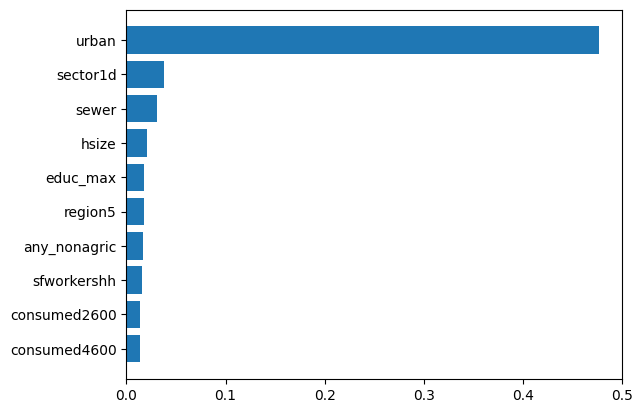

In [189]:
importances = best_xgb.feature_importances_
idx = np.argsort(importances)[-10:]
plt.barh(inputs_df.columns[idx],importances[idx])
plt.show()